In [1]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import open3d as o3d
import os
import math
import cv2
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Dataset, random_split, Subset, SubsetRandomSampler

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# The Model

In [2]:
class PointCloudAutoEncoder(nn.Module):
    def __init__(self, input_dim=32):
        super(PointCloudAutoEncoder, self).__init__()

        # Encoder: Maps input point cloud to a latent representation
        self.encoder = nn.Sequential(
            nn.Conv3d(1, 32, kernel_size=3, stride=2, padding=1),  # Output: (32, input_dim/2, input_dim/2, input_dim/2)
            nn.ReLU(),
            nn.Conv3d(32, 64, kernel_size=3, stride=2, padding=1),  # Output: (64, input_dim/4, input_dim/4, input_dim/4)
            nn.ReLU(),
            nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv3d(64, 128, kernel_size=3, stride=2, padding=1),  # Output: (128, input_dim/8, input_dim/8, input_dim/8)
            nn.ReLU(),
        )

        # Fully connected layers to create a bottleneck
        #self.flatten = nn.Flatten()  # Flatten spatial dimensions
        # self.fc1 = nn.Linear(128 * (input_dim // 8) ** 3, 128 * (input_dim // 8) ** 3)
        #self.fc2 = nn.Linear(128, 128 * (input_dim // 8) ** 3)
        #self.fc3 = nn.Linear( 128 * (input_dim // 8) ** 3, 128 * (input_dim // 8) ** 3)
        #self.fc4 = nn.Linear( 128 * (input_dim // 8) ** 3, 128 * (input_dim // 8) ** 3)
        #self.unflatten = nn.Unflatten(128 * (input_dim // 8) ** 3, (128, input_dim // 8, input_dim // 8, input_dim // 8))
        
        # Decoder: Maps latent representation back to point cloud
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose3d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose3d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose3d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose3d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose3d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),  # Output values in [0, 1]
        )

    def forward(self, x):
        # Encoder
        x = self.encoder(x)  # Encode spatial features
        #x = self.flatten(x)  # Flatten to vector
        #x = self.fc1(x)  # Compress to bottleneck
        # Decoder
        #x = self.fc2(x) 
        #x = self.fc3(x) 
        #x = self.fc4(x) 
        #x = self.unflatten(x)  # Reshape to 3D volume
        x = self.decoder(x)  # Decode back to voxel grid
        return x

In [3]:
class UNet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet3D, self).__init__()

        # Encoder (downsampling)
        self.down1 = nn.Sequential(
            nn.Conv3d(in_channels, 16, kernel_size=3, stride=2, padding=1),  # 32 -> 16
            nn.ReLU(),
        )
        self.down2 = nn.Sequential(
            nn.Conv3d(16, 32, kernel_size=3, stride=2, padding=1),  # 16 -> 8
            nn.ReLU(),
        )
        self.enc1 = self.conv_block(32, 64)  # 8 -> 8
        self.enc2 = self.conv_block(64, 128)  # 8 -> 8

        # Bottleneck
        self.bottleneck = self.conv_block(128, 128)  # 8 -> 8

        # Decoder (upsampling)
        self.upconv2 = nn.Sequential(
            nn.ConvTranspose3d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 8 -> 16
            nn.ReLU(),
        )
        self.upconv1 = nn.Sequential(
            nn.ConvTranspose3d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 16 -> 32
            nn.ReLU(),
        )

        # Final output layer
        self.final_conv = nn.Conv3d(32, out_channels, kernel_size=1)  # Match channels

    def conv_block(self, in_channels, out_channels):
        """Convolution block with 3D Conv, BatchNorm, ReLU"""
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            #nn.BatchNorm3d(out_channels),
            nn.ReLU(),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            #nn.BatchNorm3d(out_channels),
            #nn.ReLU(),
        )

    def forward(self, x):
        # Encoding path (downsampling)
        x = self.down1(x)  # 32 -> 16
        x = self.down2(x)  # 16 -> 8
        x = self.enc1(x)  # 8 -> 8
        x = self.enc2(x)  # 8 -> 8

        # Bottleneck
        x = self.bottleneck(x)  # 8 -> 8

        # Decoding path (upsampling)
        x = self.upconv2(x)  # 8 -> 16
        x = self.upconv1(x)  # 16 -> 32

        # Final convolution to match the output shape
        output = self.final_conv(x)  # 32 -> 32
        return output

In [4]:
#
# LOSS METHODS
#

from torch.nn import MSELoss
from torch.nn import BCEWithLogitsLoss

"""
COMBINED LOSS
"""
def combined_loss(pred, target):
    #return chamfer_loss(pred, target)
    loss_fn = BCEWithLogitsLoss()
    return loss_fn(pred, target)
    #mse_loss = loss_fn(pred, target)
    #ch_loss = chamfer_loss(pred, target)
    #return (mse_loss + ch_loss) * 0.5
    

# Dataset

In [5]:
class VoxelGridDataset(Dataset):
    def __init__(self, root_dir, split="train",transform=None):
        """
        Args:
            root_dir (str): Root directory containing subfolders with .ply files.
            split (str): 'train' or 'val'. Determines the file names.
            target_points (int): Number of points to standardize the point clouds to.
            transform (callable, optional): Optional transform to apply to the point clouds.
        """
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.samples = []
        
        self.voxel_size = None
        self.grid_min_bound = None
        self.grid_min_bound = None

        # Gather all subfolder paths and corresponding files
        """
        for subfolder in os.listdir(root_dir):
            subfolder_path = os.path.join(root_dir, subfolder)
            if os.path.isdir(subfolder_path):
                incomplete_path = os.path.join(subfolder_path, f"{subfolder}h.ply")
                ground_truth_path = os.path.join(subfolder_path, f"{subfolder}.ply")
                if os.path.exists(incomplete_path) and os.path.exists(ground_truth_path):
                    self.samples.append((incomplete_path, ground_truth_path))
        """
        
        lst = os.listdir(root_dir) # your directory path
        number_files = len(lst)

        for i in range(math.floor(number_files / 2)):
            cut_file_path = os.path.join(root_dir, f"{i}_cut.ply")
            full_file_path = os.path.join(root_dir, f"{i}_full.ply")
            if os.path.exists(cut_file_path) and os.path.exists(full_file_path):
                self.samples.append((cut_file_path, full_file_path))
                    
        print(f"Created dataset with {len(self.samples)} entries")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # Load the incomplete and ground truth point clouds
        incomplete_path, ground_truth_path = self.samples[idx]

        incomplete_pcd = o3d.io.read_point_cloud(incomplete_path)
        ground_truth_pcd = o3d.io.read_point_cloud(ground_truth_path)

        incomplete_points = self.get_3d_tensor_from_pcd(incomplete_pcd)
        ground_truth_points = self.get_3d_tensor_from_pcd(ground_truth_pcd)
        
        # add one color channel for tensor format
        incomplete_points = incomplete_points.unsqueeze(0)
        ground_truth_points = ground_truth_points.unsqueeze(0) 
        
        # Apply transformations if any
        if self.transform:
            incomplete_points = self.transform(incomplete_points)
            ground_truth_points = self.transform(ground_truth_points)

        return incomplete_points, ground_truth_points
    
    
    def get_3d_tensor_from_pcd(self, pcd):
        # Extract the points
        points = np.asarray(pcd.points)
        # Get the bounding box of the point cloud to determine the extent of the grid
        min_bound = np.min(points, axis=0)
        max_bound = np.max(points, axis=0)
        # Define the resolution of the 3D grid (e.g., 50x50x50 grid)
        grid_size = 32 # TODO IN PARAMS
        voxel_size = (max_bound - min_bound) / grid_size
        
        self.voxel_size = voxel_size
        self.grid_min_bound = min_bound
        self.grid_min_bound = max_bound
        
        # Normalize the points to the grid space
        normalized_points = (points - min_bound) / voxel_size
        # Round the points to the nearest grid cell
        grid_points = np.floor(normalized_points).astype(int)
        # Clamp the values to ensure they stay within grid bounds
        grid_points = np.clip(grid_points, 0, grid_size - 1)
        # Create the 3D tensor (grid), initially filled with zeros
        grid_tensor = torch.zeros((grid_size, grid_size, grid_size), dtype=torch.int32)
        # Mark the grid cells corresponding to the points as occupied (1)
        for point in grid_points:
            grid_tensor[tuple(point)] = 1
        return grid_tensor.float()
    
    def visualize_3d_torch(self, tensor_3d, threshold=0.5):
        # Convert grid_tensor (PyTorch tensor) to NumPy array for indexing
        grid_array = tensor_3d.numpy()
        # Get the indices of non-zero values (voxels that are occupied)
        occupied_voxels = np.array(np.where(grid_array >= threshold)).T
        # Convert voxel indices to real-world coordinates
        real_world_coords = occupied_voxels * self.voxel_size + self.grid_min_bound
        # Create a point cloud object
        pcd_voxels = o3d.geometry.PointCloud()
        # Set the points of the point cloud (the occupied voxel coordinates)
        pcd_voxels.points = o3d.utility.Vector3dVector(real_world_coords)
        # Optionally, you can color the points if needed (e.g., blue color)
        pcd_voxels.paint_uniform_color([0, 0, 1])  # RGB color
        # Visualize the point cloud
        o3d.visualization.draw_geometries([pcd_voxels], window_name="Voxel Grid Visualization")

# Training

In [6]:
def validate_autoencoder(model, dataloader, device='cuda'):
    model.eval()
    total_loss = 0.0
    
    with torch.no_grad():
        for incomplete_pc, ground_truth_pc in dataloader:
            incomplete_pc = incomplete_pc.to(device)
            ground_truth_pc = ground_truth_pc.to(device)

            # Get the reconstructed point cloud
            reconstructed_pc = model(incomplete_pc)

            # Calculate the loss against the ground truth
            loss = combined_loss(reconstructed_pc, ground_truth_pc)
            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return avg_loss

def train_with_ground_truth(model, optimizer, train_loader, val_loader, epochs=50, device='cuda'):
    model.to(device)
    
    best_loss = float('inf')
    patience = 7
    
    train_losses = []
    val_losses = []
    
    print("starting epochs")
    
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0.0
        
        for incomplete_pc, ground_truth_pc in train_loader:
            incomplete_pc = incomplete_pc.to(device)
            ground_truth_pc = ground_truth_pc.to(device)
            
            # Reconstruct point cloud
            reconstructed_pc = model(incomplete_pc)

            # Compute loss against ground truth
            loss = combined_loss(reconstructed_pc, ground_truth_pc)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = validate_autoencoder(model, val_loader, device)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        # Early stopping
        if avg_train_loss < best_loss:
            best_loss = avg_train_loss
            patience = 7  # Reset patience counter
        else:
            patience -= 1
            if patience == 0:
                print("EARLY STOPPING DUE TO MISSING PROGRESS")
                break
        
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [8]:
 # Dataset root directory
root_dir = "../assets/voxel10000"

# Create dataset and dataloaders
full_dataset = VoxelGridDataset(root_dir=root_dir, split="train")

#limit to 10k
indices = np.random.choice(len(full_dataset), size=1000, replace=False)
subset_d = Subset(full_dataset, indices)

# Define the split ratio (e.g., 80% train, 20% validation)
train_size = int(0.8 * len(subset_d))
val_size = len(subset_d) - train_size
print(f"train size: {train_size}, val size: {val_size}")
train_dataset, val_dataset = random_split(subset_d, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

demo_entry = val_dataset[1]
print(np.shape(demo_entry))

full_dataset.visualize_3d_torch(demo_entry[1][0])
#full_dataset.visualize_3d_torch(demo_entry[0][0])
#print(demo_entry)
#visualize_point_cloud(demo_entry)

Created dataset with 29340 entries
train size: 800, val size: 200
(2, 1, 32, 32, 32)


In [58]:
# Initialize model, optimizer
epochs = 20
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model = PointCloudAutoEncoder()

cuda


starting epochs
Epoch 1/20, Train Loss: 0.8028, Val Loss: 0.6956
Epoch 2/20, Train Loss: 0.6938, Val Loss: 0.6934
Epoch 3/20, Train Loss: 0.6934, Val Loss: 0.6935
Epoch 4/20, Train Loss: 0.6940, Val Loss: 0.6940
Epoch 5/20, Train Loss: 0.6935, Val Loss: 0.6933
Epoch 6/20, Train Loss: 0.6933, Val Loss: 0.6933
Epoch 7/20, Train Loss: 0.6933, Val Loss: 0.6933
Epoch 8/20, Train Loss: 0.6933, Val Loss: 0.6933
Epoch 9/20, Train Loss: 0.6933, Val Loss: 0.6933
Epoch 10/20, Train Loss: 0.6933, Val Loss: 0.6933
Epoch 11/20, Train Loss: 0.6933, Val Loss: 0.6933
Epoch 12/20, Train Loss: 0.6933, Val Loss: 0.6933
Epoch 13/20, Train Loss: 0.6933, Val Loss: 0.6933
Epoch 14/20, Train Loss: 0.6933, Val Loss: 0.6933
Epoch 15/20, Train Loss: 0.6933, Val Loss: 0.6933
Epoch 16/20, Train Loss: 0.6933, Val Loss: 0.6933
Epoch 17/20, Train Loss: 0.6933, Val Loss: 0.6933
Epoch 18/20, Train Loss: 0.6933, Val Loss: 0.6933
Epoch 19/20, Train Loss: 0.6933, Val Loss: 0.6933
Epoch 20/20, Train Loss: 0.6933, Val Loss: 

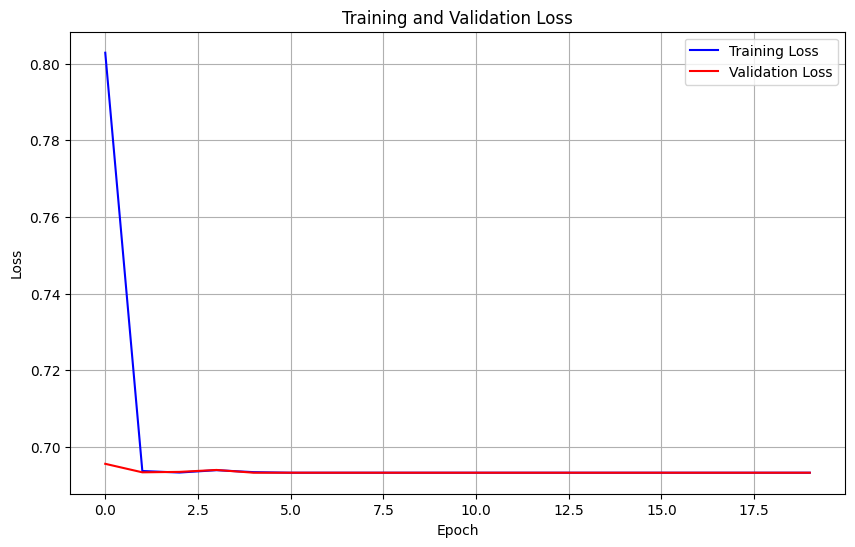

In [59]:
# Train with grund truth
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_with_ground_truth(model, optimizer, train_loader, val_loader, epochs=epochs, device=device)

# Evaluation / Test

In [46]:
# Get a single example
pd_input, pd_truth = train_dataset[9]  # First sample from the dataset
pd_input = pd_input.unsqueeze(0)  # Add batch dimension (1, num_points, 3)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
pd_input = pd_input.to(device)

#state_dict = torch.load("../assets/model_exports/model_v1.pt")
#model.load_state_dict(state_dict)
#model.eval()

# Run through the model
with torch.no_grad():
    reconstructed_pc = model(pd_input)
    
# Remove batch dimension
pd_input = pd_input.squeeze(0).cpu()
reconstructed_pc = reconstructed_pc.squeeze(0).cpu()
pd_truth = pd_truth.cpu()
#plot_point_cloud(pd_truth)

#print(torch.max(reconstructed_pc))
reconstructed_pc = torch.where(reconstructed_pc > 0, 1, 0)
print(np.shape(reconstructed_pc))
print(torch.max(reconstructed_pc))
print(torch.max(pd_input))
print(np.shape(pd_input))

full_dataset.visualize_3d_torch(pd_input[0])
full_dataset.visualize_3d_torch(reconstructed_pc[0])

torch.Size([1, 32, 32, 32])
tensor(1)
tensor(1.)
torch.Size([1, 32, 32, 32])


In [38]:
torch.save(model, '../assets/model_exports/model_v2.pt')

# Other Experiments

### Testing the Losses

In [15]:
#
# IOU Loss visualization
#

pd_input, pd_truth = train_dataset[9]
pd_input = pd_input.unsqueeze(0)
print(np.shape(pd_input))
pd_truth = pd_truth.unsqueeze(0)

#input_voxels = voxelize_point_cloud(pd_input, voxel_size=0.1)

#print(f"IOUT Loss: {iou_loss(pd_input, pd_truth)}")
print(f"Chamfer Loss Loss: {chamfer_loss(pd_input, pd_truth)}")

torch.Size([1, 1024, 3])
Chamfer Loss Loss: 0.3967241942882538
